# Problem Stable Marriage

See [Wikipedia](https://en.wikipedia.org/wiki/Stable_marriage_problem). 
Consider two groups of men and women who must marry. Consider that each person has indicated a ranking for her/his possible spouses. The problem is to find a matching between the two groups such that the marriages are stable.
A marriage between a man $m$ and a woman $w$ is stable iff:
- whenever $m$ prefers an other woman $o$ to $w$, $o$ prefers her husband to $m$
- whenever $w$ prefers an other man $o$ to $m$, $o$ prefers his wife to $w$

In 1962, David Gale and Lloyd Shapley proved that, for any equal number $n$ of men and women, it is always possible to make all marriages stable, with an algorithm running in $O(n^2)$. Nevertheless, this problem remains interesting as it shows how a nice and compact model can be written.

Marrying People. <small>Image from [freesvg.org](https://freesvg.org/group-of-men-and-women-silhouettes)</small>
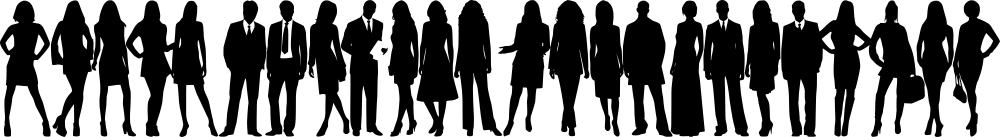

To build a CSP (Constraint Satisfaction Problem) model, we need first to import the library PyCSP$^3$:

In [1]:
from pycsp3 import *

Then, we need some data. Here, we have two arrays with the preferences of women and men. For example, wrankings[2][0] is the most preferred man by woman 2.  

In [2]:
wrankings = cp_array([[1,2,4,3,5], [3,5,1,2,4], [5,4,2,1,3], [1,3,5,4,2], [4,2,3,5,1]])
mrankings = cp_array([[5,1,2,4,3], [4,1,3,2,5], [5,3,2,4,1], [1,5,4,3,2], [4,3,2,1,5]])

Note that we need to transform the lists of integers into more specific lists with the function *cp_array()* because, otherwise it is not possible to use a special object (here, an object Var) as an index of a list of integers in Python (and this is what we do later when posting some constraints). The good news is that when the data is loaded from a file (which is the usual case), all lists of integers have the specific type of list returned by cp_array(), and so, it is very rare to need to call this function explicitly.

We define a few constants.

In [3]:
n = len(wrankings)
Men, Women = range(n), range(n)

We start our CSP model by introducing two arrays $w$ and $h$ of $n$ variables. Although that one array would be technically sufficient to determine the marriages, introducing the two arrays will simplify our task of enforcing stability.

In [4]:
# x[m] is the wife of the man m
x = VarArray(size=n, dom=Women)

# y[w] is the husband of the woman w
y = VarArray(size=n, dom=Men)

We can display the structure of the array, as well as the domain of the first variable (note that all variables have the same domain).

In [5]:
print("Array x: ", x)
print("Array y: ", y)
print("Domain of any variable: ", x[0].dom)

Array x:  [x[0], x[1], x[2], x[3], x[4]]
Array y:  [y[0], y[1], y[2], y[3], y[4]]
Domain of any variable:  0..4


Concerning the constraints, we start by posting a constraint *Channel* in order to ensure that marriages are equivalent from both points of view.

In [6]:
satisfy(
  # spouses must match
  Channel(x, y)
);

Interestingly, by calling the function *solve()*, we can check that the problem is satisfiable (SAT). We can also display the found solution. Here, we call the function *values()* that collects the values assigned to a specified list of variables.

In [7]:
if solve() is SAT:
    print("Wifes:    ", values(x))
    print("Husbands: ", values(y))

Wifes:     [0, 1, 2, 3, 4]
Husbands:  [0, 1, 2, 3, 4]


On can observe that marriages are proposed, but preferences are certainly badly respected.

There is no reason for a man to have his wife changed with another woman if this woman prefers her husband to the man. We post a group of constraints *Intension* involving subexpressions corresponding to constraints *Element*.

In [8]:
satisfy(
    # whenever m prefers an other woman o to his wife, o prefers her husband to m
    If(
        mrankings[m][o] < mrankings[m][x[m]],
        Then=wrankings[o][y[o]] < wrankings[o][m]
    ) for m in Men for o in Women
);

Similarly, there is no reason for a woman to have his husband changed with another man if this man prefers his wife to the woman.  

In [9]:
satisfy(
    # whenever w prefers an other man o to her husband, o prefers his wife to w
    If(
        wrankings[w][o] < wrankings[w, y[w]],
        Then=mrankings[o][x[o]] < mrankings[o][w]
    ) for w in Women for o in Men
);

We can run again the solver.

In [10]:
if solve() is SAT:
    print("Wifes:    ", values(x))
    print("Husbands: ", values(y))

Wifes:     [1, 0, 4, 2, 3]
Husbands:  [1, 0, 3, 4, 2]


The reader can check that the marriages are stable.

On can display the three possible solutions for this problem instance.

In [11]:
if solve(sols=ALL) is SAT:
    for i in range(n_solutions()):
        print("Solution ", i+1)
        print("  Wifes:    ", values(x,sol=i))
        print("  Husbands: ", values(y,sol=i))

Solution  1
  Wifes:     [1, 0, 4, 2, 3]
  Husbands:  [1, 0, 3, 4, 2]
Solution  2
  Wifes:     [1, 2, 4, 0, 3]
  Husbands:  [3, 0, 1, 4, 2]
Solution  3
  Wifes:     [3, 0, 1, 2, 4]
  Husbands:  [1, 2, 3, 0, 4]


Finally, we give below the model in one piece. Here the data is expected to be given by the user (in a command line).